Tutorial 4. Working with Generative Adversarial Networks on top of Neural Wrappers
==================================================

This is the fourth tutorial and it focuses on the implementation of the GANs, under `neural_wrappers.generative_adversarial_network`.

This isn't a comprehensive GAN tutorial, but rather a high level API introduction to the GAN implementation. The purpose is to generate MNIST digits in an usupervised learning fashion.

### 1. Definining the GAN reader

Like in most tutorial, we'll use the MNIST dataset, which is assumed already converted (as covered in tutorial 2).

The GAN network require a special protocol for the generated data. Instead of generating `(data, labels)` pairs, we will generate the following data `(data, data)` and let the unsupervised algorithm learn the distribution itself. 

In [10]:
import numpy as np
from overrides import overrides
from neural_wrappers.readers import H5DatasetReader
from neural_wrappers.utilities import getGenerators, toCategorical

# For some reasons, results are much better if provided data is in range -1 : 1 (not 0 : 1 or standardized).
class GANReader(H5DatasetReader):
    def __init__(self, datasetPath:str):
        self.datasetPath = datasetPath

        super().__init__(
            datasetPath,
            dataBuckets = {"data" : ["rgb"]},
            dimGetter = {"rgb" : \
                lambda dataset, index : dataset["images"][index.start : index.end]},
            dimTransform = {
                "data" : {"rgb" : lambda x : (np.float32(x) / 255 - 0.5) * 2}
            }
        )

    @overrides
    def iterateOneEpoch(self, topLevel : str, batchSize : int):
        for items in super().iterateOneEpoch(topLevel, batchSize):
            rgb = items["data"]["rgb"]
            yield rgb, rgb

    @overrides
    def getNumData(self, topLevel : str) -> int:
        return len(self.dataset[topLevel]["images"])

reader = GANReader("/home/mihai/Public/Datasets/MNIST/dataset.h5")
print(reader.summary())

generator, numSteps = getGenerators(reader, batchSize=20, keys=["train"])
print("Train steps:", numSteps)

[Dataset summary]
General dataset reader (<class '__main__.GANReader'>). Update __str__ in your dataset for more details when using summary.
Data buckets:
 -  data : ['rgb']

Train steps: 3000


#### 2. Defining the Generator and Discriminator models

The GAN works by having two competing Neural Networks that are trained to minimize two distinctive losses. The Generator must generate, starting from random noise, an image that resembles the original dataset. This fake image alongside a real image is sent to the Discriminator and it must classify which is real and which is fake.

This is generalized by having multiple images sent at once (real and fake) as well as having variable number of steps for each model (however 1 step each is stable enough to not get any of the models too strong causing the other one to never learn anything anymore).

The algorithm can be described as such:

```
realData = next(reader)[0]
# detach so we only optimize D
fakeDataD = Generator(noise).detach()
L = LD(fakeDataD, zeros) + LD(realData, ones)
OptimizeD(L)

fakeDataG = Generator(noise)
L = LD(fakeDataG, ones)
# optimize G only here
OptimizeG(L)
```

The loss function for the discrimator is BCE, with ones for real data and zeros for fake data.

In [11]:
import torch as tr
import torch.nn.functional as F
import torch.nn as nn
from neural_wrappers.pytorch import FeedForwardNetwork

class Generator(FeedForwardNetwork):
    def __init__(self, inputSize, outputSize):
        super().__init__()
        assert len(outputSize) == 3
        self.noiseSize = inputSize
        self.inputSize = inputSize
        self.outputSize = outputSize

        self.fc1 = nn.Linear(self.inputSize, 128)
        self.fc2 = nn.Linear(128, 256)
        self.bn2 = nn.BatchNorm1d(256)
        self.fc3 = nn.Linear(256, 512)
        self.bn3 = nn.BatchNorm1d(512)
        self.fc4 = nn.Linear(512, 1024)
        self.bn4 = nn.BatchNorm1d(1024)
        self.fc5 = nn.Linear(1024, outputSize[0] * outputSize[1] * outputSize[2])

    def forward(self, x):
        y1 = F.leaky_relu(self.fc1(x))
        y2 = F.leaky_relu(self.bn2(self.fc2(y1)), negative_slope=0.2)
        y3 = F.leaky_relu(self.bn3(self.fc3(y2)), negative_slope=0.2)
        y4 = F.leaky_relu(self.bn4(self.fc4(y3)), negative_slope=0.2)
        y5 = tr.tanh(self.fc5(y4))
        y5 = y5.view(-1, *self.outputSize)
        return y5

class Discriminator(FeedForwardNetwork):
    def __init__(self, inputSize):
        super().__init__()
        assert len(inputSize) == 3
        self.inputSize = inputSize
        self.fc1 = nn.Linear(inputSize[0] * inputSize[1] * inputSize[2], 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)

    def forward(self, x):
        x = x.view(-1, self.inputSize[0] * self.inputSize[1] * self.inputSize[2])
        y1 = F.leaky_relu(self.fc1(x), negative_slope=0.2)
        y2 = F.leaky_relu(self.fc2(y1), negative_slope=0.2)
        y3 = tr.sigmoid(self.fc3(y2))
        y3 = y3.view(y3.shape[0])
        return y3


#### 2.1 Wrapping the models inside a GAN model.

We'll wrap the two models inside a GAN model that implements the logic defined earlier.

In [15]:
import torch.optim as optim
from neural_wrappers.pytorch import GenerativeAdversarialNetwork, device
from neural_wrappers.callbacks import SaveModels, PlotMetrics

generatorModel = Generator(inputSize=100, outputSize=(28, 28, 1))
discriminatorModel = Discriminator(inputSize=(28, 28, 1))

# Define model
model = GenerativeAdversarialNetwork(generator=generatorModel, discriminator=discriminatorModel).to(device)
model.setOptimizer(optim.SGD, lr=0.01)

#### 3. Training the model

This is a standard training pipeline that looks identical to previous tutorials. Also, for each epoch, we'll print a few samples to see the model's improvement in time using a custom callback.

In [16]:
from neural_wrappers.callbacks import Callback
import matplotlib.pyplot as plt
%matplotlib inline

class PlotCallback(Callback):
    def __init__(self, latentSpaceSize):
        super().__init__("PlotCallback")
        self.latentSpaceSize = latentSpaceSize

    def onEpochEnd(self, **kwargs):
        GAN = kwargs["model"]

        # Generate 20 random gaussian inputs
        randomNoise = np.random.randn(20, self.latentSpaceSize).astype(np.float32)
        npRandomOutG = GAN.generator.npForward(randomNoise)[..., 0] / 2 + 0.5

        # Plot the inputs and discriminator's confidence in them
        items = [npRandomOutG[j] for j in range(len(npRandomOutG))]

        ax = plt.subplots(4, 5)[1]
        for i in range(4):
            for j in range(5):
                ax[i, j].imshow(npRandomOutG[i * 4 + j], cmap="gray")
        plt.show()

model.addCallbacks([SaveModels("last", "Loss"), PlotMetrics(["Loss"]), PlotCallback(100)])
print(model.summary())

[Model summary]
General neural network architecture. Update __str__ in your model for more details when using summary.
Parameters count: 2047124. Trainable parameters: 2047124.
Hyperparameters:
Metrics:
	- Loss (min)
Callbacks:
	SaveModels (Metric: Loss. Type: last) | PlotMetrics (Loss, Loss) | PlotCallback
Optimizer: ['Generic Optimizer. GAN OPTIMIZER']
Optimizer Scheduler: None
GPU: True


[Train] Iteration:   1%|          | 17/3000 [00:00<00:18, 165.00it/s]

Training for 10 epochs starting from epoch 1




[Train] Iteration:  70%|███████   | 2101/3000 [00:11<00:04, 180.84it/s]


Epoch:  10%|█         | 1/10 [00:16<02:25, 16.13s/it]

[SaveModels] Epoch 2. Saved last model


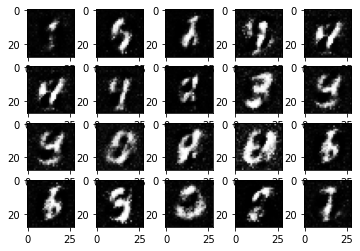

[Train] Iteration:  71%|███████   | 2123/3000 [00:11<00:04, 182.13it/s]


Epoch:  20%|██        | 2/10 [00:33<02:17, 17.15s/it]

[SaveModels] Epoch 3. Saved last model


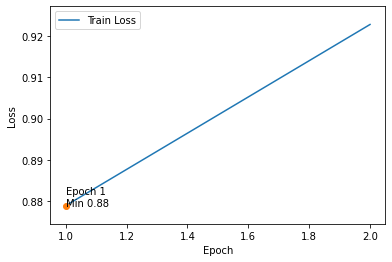

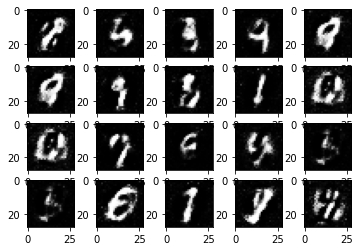

[Train] Iteration:  66%|██████▌   | 1986/3000 [00:11<00:05, 172.99it/s]


Epoch:  30%|███       | 3/10 [00:52<02:00, 17.19s/it]

[SaveModels] Epoch 4. Saved last model


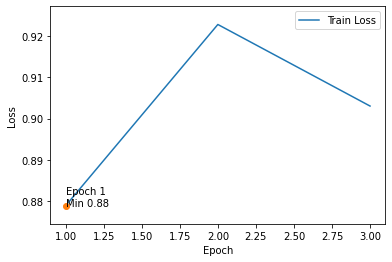

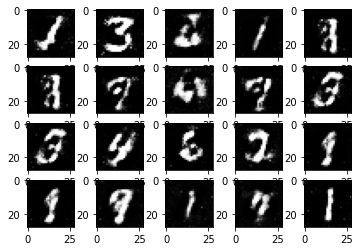

[Train] Iteration:  70%|██████▉   | 2095/3000 [00:11<00:04, 191.26it/s]


Epoch:  40%|████      | 4/10 [01:09<01:46, 17.67s/it]

[SaveModels] Epoch 5. Saved last model


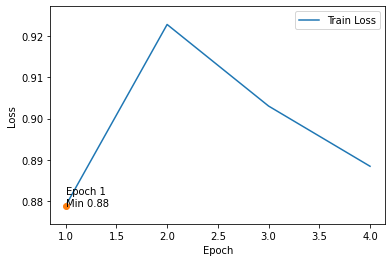

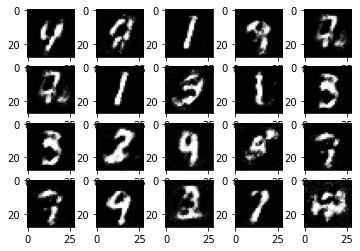

[Train] Iteration:  70%|██████▉   | 2091/3000 [00:11<00:05, 167.04it/s]


Epoch:  50%|█████     | 5/10 [01:26<01:27, 17.60s/it]

[SaveModels] Epoch 6. Saved last model


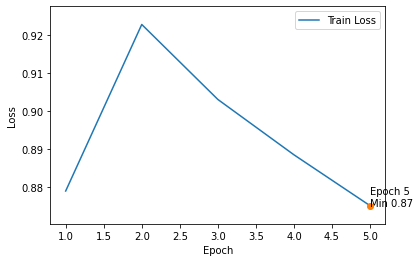

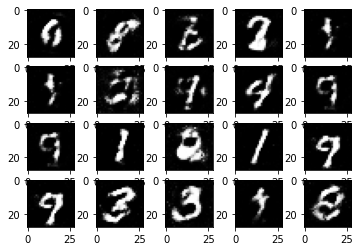

[Train] Iteration:  68%|██████▊   | 2046/3000 [00:11<00:05, 187.90it/s]


Epoch:  60%|██████    | 6/10 [01:44<01:10, 17.57s/it]

[SaveModels] Epoch 7. Saved last model


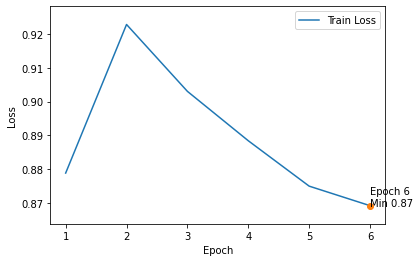

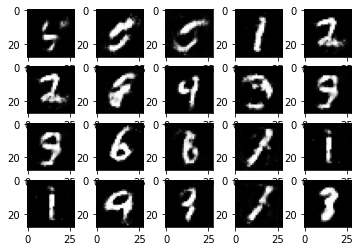

[Train] Iteration:  68%|██████▊   | 2037/3000 [00:11<00:05, 185.79it/s]


Epoch:  70%|███████   | 7/10 [02:02<00:52, 17.62s/it]

[SaveModels] Epoch 8. Saved last model


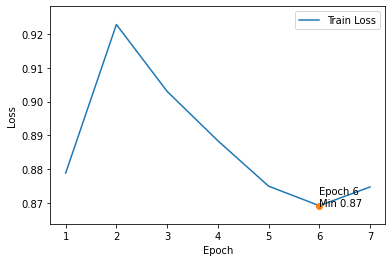

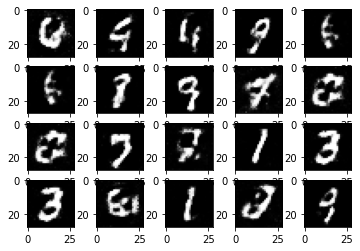

[Train] Iteration:  67%|██████▋   | 2020/3000 [00:11<00:06, 159.73it/s]


Epoch:  80%|████████  | 8/10 [02:20<00:35, 17.62s/it]

[SaveModels] Epoch 9. Saved last model


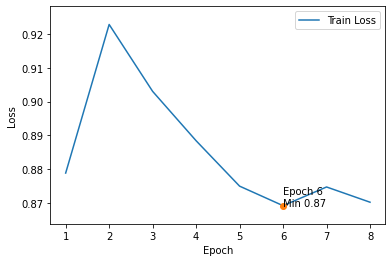

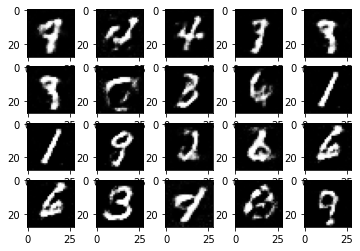

[Train] Iteration:  70%|███████   | 2101/3000 [00:11<00:04, 190.01it/s]


Epoch:  90%|█████████ | 9/10 [02:37<00:17, 17.79s/it]

[SaveModels] Epoch 10. Saved last model


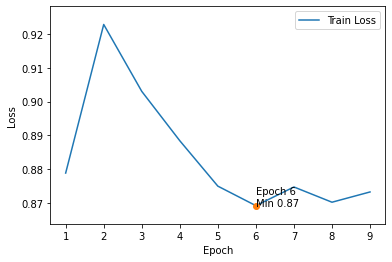

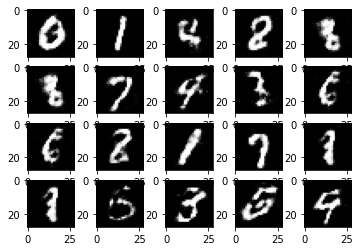

[Train] Iteration:  70%|██████▉   | 2096/3000 [00:11<00:04, 184.31it/s]


Epoch: 100%|██████████| 10/10 [02:55<00:00, 17.62s/it]

[SaveModels] Epoch 11. Saved last model


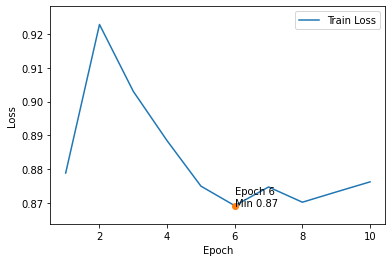

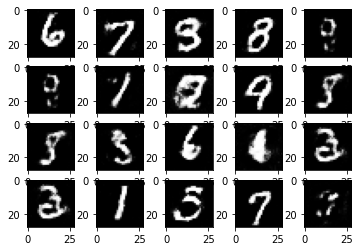

Epoch: 11it [02:56, 16.04s/it]                        


In [17]:
model.train_generator(generator, numSteps, numEpochs=10)

#### 4. Testing the model

We'll pick the latest stored model and generate some samples from random noise to see its quality as well as discriminator's response.

Loading model from model_last.pkl
Succesfully loaded weights (2047124 parameters) 
Succesfully loaded optimizer: ['Generic Optimizer. GAN OPTIMIZER']
Succesfully loaded model history (epoch 10)
Succesfully loaded 4 callbacks (1 metrics)
Finished loading model


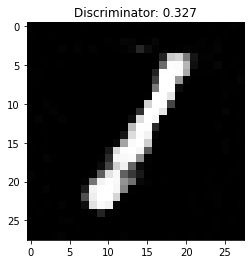

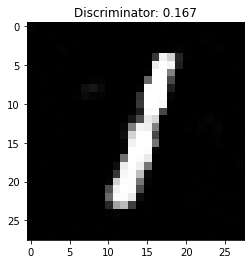

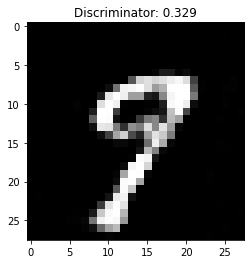

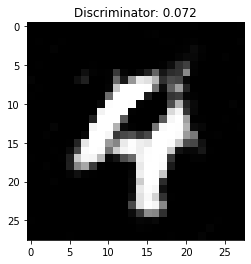

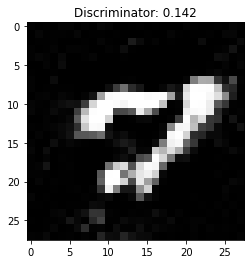

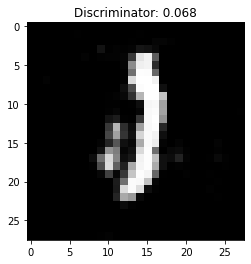

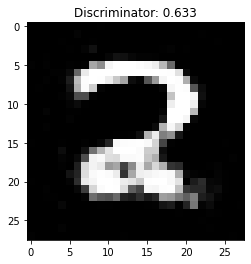

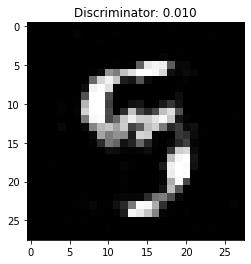

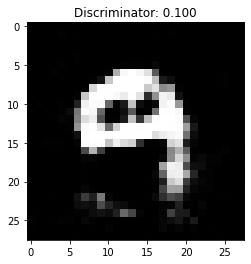

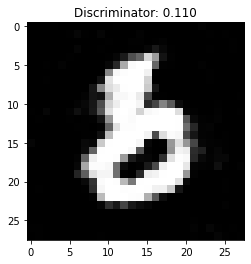

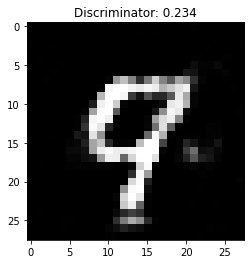

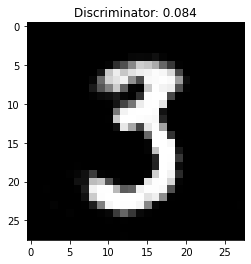

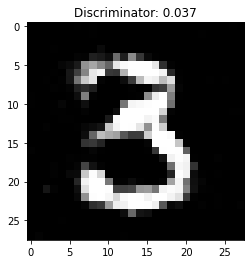

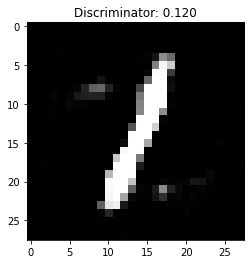

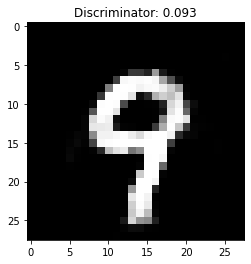

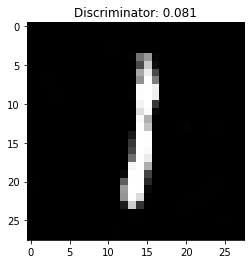

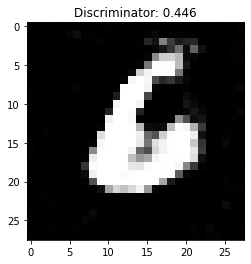

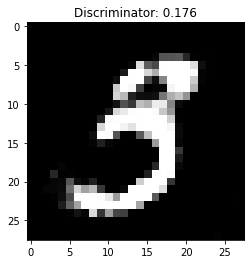

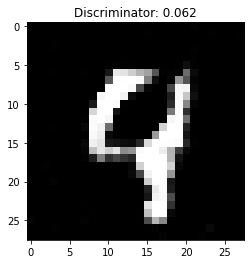

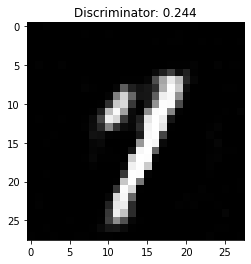

In [19]:
model.loadModel("model_last.pkl")

# Batches of 20, noise of 100 dims
randomInputsG = np.random.randn(20, 100).astype(np.float32)
randomOutG = model.generator.npForward(randomInputsG)
outD = model.discriminator.npForward(randomOutG)
randomOutG = randomOutG[..., 0]
for j in range(20):
    plt.imshow(randomOutG[j], cmap="gray")
    plt.title("Discriminator: %2.3f" % (outD[j]))
    plt.show()